In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report, precision_score, f1_score

# ---------- 0. PATH HANDLING (works from root or notebooks/) ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)

BASE_DIR: d:\redact


In [3]:
full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print("full_data shape:", full_data.shape)
print("edgelist shape:", edgelist.shape)

# ---------- 2. BUILD NODE INDEX MAPPING ----------

# Sort by txId to have consistent ordering
full_data = full_data.sort_values("txId").reset_index(drop=True)

tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}

num_nodes = len(tx_ids)
print("Number of nodes:", num_nodes)


full_data shape: (203769, 169)
edgelist shape: (234355, 2)
Number of nodes: 203769


In [4]:
# Map txId1, txId2 -> node indices
src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

# Drop edges where either endpoint is missing in mapping
mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

print("edge_index shape:", edge_index.shape)

edge_index shape: torch.Size([2, 234355])


In [5]:
# Drop non-feature columns
feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)

# Labels: 0 (normal), 1 (fraud), -1 (unknown)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print("Feature matrix shape:", x.shape)
print("Label distribution (including unknown):", pd.Series(y_np).value_counts())

Feature matrix shape: torch.Size([203769, 166])
Label distribution (including unknown): -1    157205
 0     42019
 1      4545
Name: count, dtype: int64


In [6]:
time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0          # only where we have 0/1
train_mask = (time_steps <= 32) & labeled_mask
test_mask  = (time_steps > 32) & labeled_mask

# Create a small validation set from train labeled nodes (10%)
train_indices = np.where(train_mask)[0]
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

# Build final boolean masks
final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)

final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print("Train nodes:", train_mask_t.sum().item())
print("Val nodes:", val_mask_t.sum().item())
print("Test nodes:", test_mask_t.sum().item())

Train nodes: 26045
Val nodes: 2893
Test nodes: 17626


In [7]:
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
)

data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
print("Using device:", device)

Using device: cuda


In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        return x

in_channels = data.x.size(1)
hidden_channels = 64
out_channels = 2  # normal vs fraud

model = GraphSAGE(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(model)


GraphSAGE(
  (conv1): SAGEConv(166, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
EPOCHS = 40
best_val_f1 = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    val_report, val_precision, val_f1 = evaluate(data.val_mask)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1 (fraud): {val_f1:.4f}")

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 005 | Loss: 0.5031 | Val F1 (fraud): 0.0270
Epoch 010 | Loss: 0.3936 | Val F1 (fraud): 0.0000
Epoch 015 | Loss: 0.3519 | Val F1 (fraud): 0.0000
Epoch 020 | Loss: 0.3114 | Val F1 (fraud): 0.0000
Epoch 025 | Loss: 0.2769 | Val F1 (fraud): 0.0000
Epoch 030 | Loss: 0.2514 | Val F1 (fraud): 0.0449
Epoch 035 | Loss: 0.2328 | Val F1 (fraud): 0.2005
Epoch 040 | Loss: 0.2221 | Val F1 (fraud): 0.3273


In [11]:
test_report, test_precision, test_f1 = evaluate(data.test_mask)
print("\n=== GNN TEST RESULTS (fraud class) ===")
print("Precision:", test_precision)
print("F1 Score:", test_f1)

# Show full sklearn-style report
out = model(data.x, data.edge_index)
logits_test = out[data.test_mask]
labels_test = data.y[data.test_mask].cpu().numpy()
preds_test = logits_test.argmax(dim=1).cpu().numpy()

print("\nFull classification report on test labeled nodes:")
print(classification_report(labels_test, preds_test, zero_division=0))


=== GNN TEST RESULTS (fraud class) ===
Precision: 0.25706010137581464
F1 Score: 0.28129952456418383

Full classification report on test labeled nodes:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     16483
           1       0.26      0.31      0.28      1143

    accuracy                           0.90     17626
   macro avg       0.60      0.62      0.61     17626
weighted avg       0.91      0.90      0.90     17626



In [13]:
with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1]  # probability of fraud class

probs_all_np = probs_all.cpu().numpy()

full_data["gnn_fraud_prob"] = probs_all_np
full_data["gnn_pred_label"] = (probs_all_np >= 0.5).astype(int)

gnn_pred_path = os.path.join(PROC_DIR, "gnn_predictions.csv")
full_data.to_csv(gnn_pred_path, index=False)

model_path = os.path.join(MODEL_DIR, "gnn_model.pt")
torch.save(model.state_dict(), model_path, _use_new_zipfile_serialization=False)

print("\nSaved GNN fraud probabilities to:", gnn_pred_path)
print("Saved GNN model to:", model_path)


Saved GNN fraud probabilities to: d:\redact\data\processed\gnn_predictions.csv
Saved GNN model to: d:\redact\models\gnn_model.pt


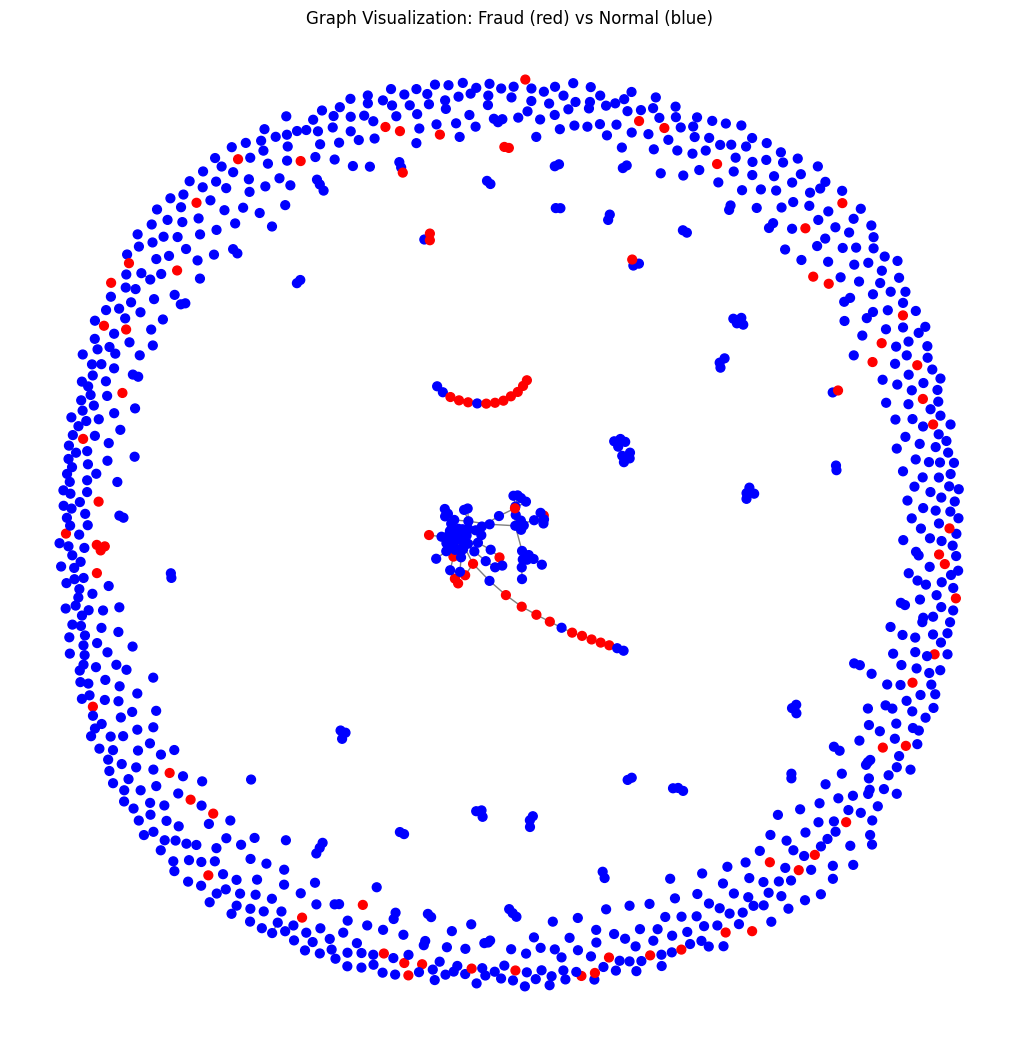

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Take a subgraph for visualization: first 1,000 nodes
num_visual_nodes = 1000
subset_nodes = list(range(num_visual_nodes))

# Mask edges to show only those inside the subset
mask = (edge_index[0] < num_visual_nodes) & (edge_index[1] < num_visual_nodes)
subset_edges = edge_index[:, mask].cpu().numpy()

G = nx.Graph()
G.add_nodes_from(subset_nodes)
G.add_edges_from(list(zip(subset_edges[0], subset_edges[1])))

# Color by fraud prediction from GNN
colors = ["red" if full_data.loc[n, "gnn_pred_label"] == 1 else "blue"
          for n in subset_nodes]

plt.figure(figsize=(10,10))
nx.draw(G, pos=nx.spring_layout(G, seed=42),
        node_color=colors, node_size=40, edge_color='gray')
plt.title("Graph Visualization: Fraud (red) vs Normal (blue)")
plt.show()


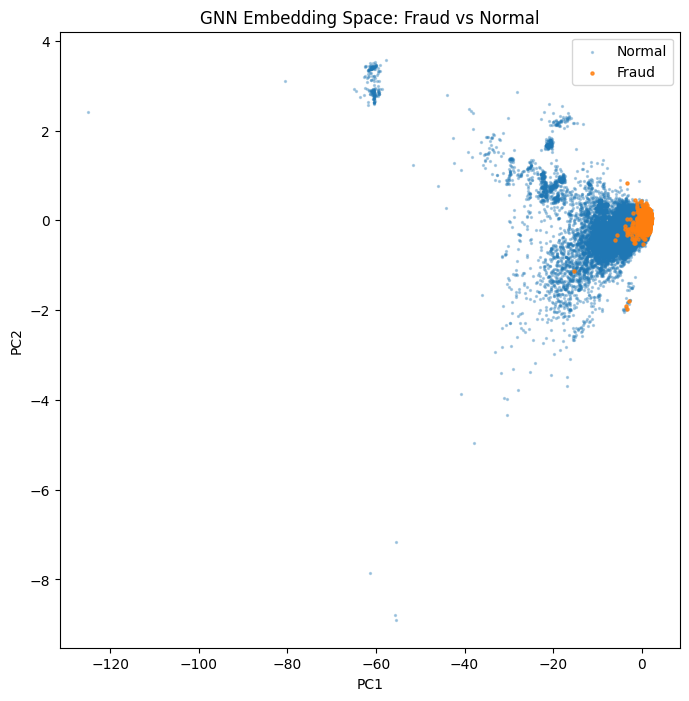

In [15]:
from sklearn.decomposition import PCA

embeddings = out_all.cpu().numpy()  # Use logits as embeddings
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

labels = full_data['binary_label'].values

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[labels==0,0], emb_2d[labels==0,1], s=2, label='Normal', alpha=0.3)
plt.scatter(emb_2d[labels==1,0], emb_2d[labels==1,1], s=5, label='Fraud', alpha=0.8)
plt.legend()
plt.title("GNN Embedding Space: Fraud vs Normal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


NameError: name 'df' is not defined

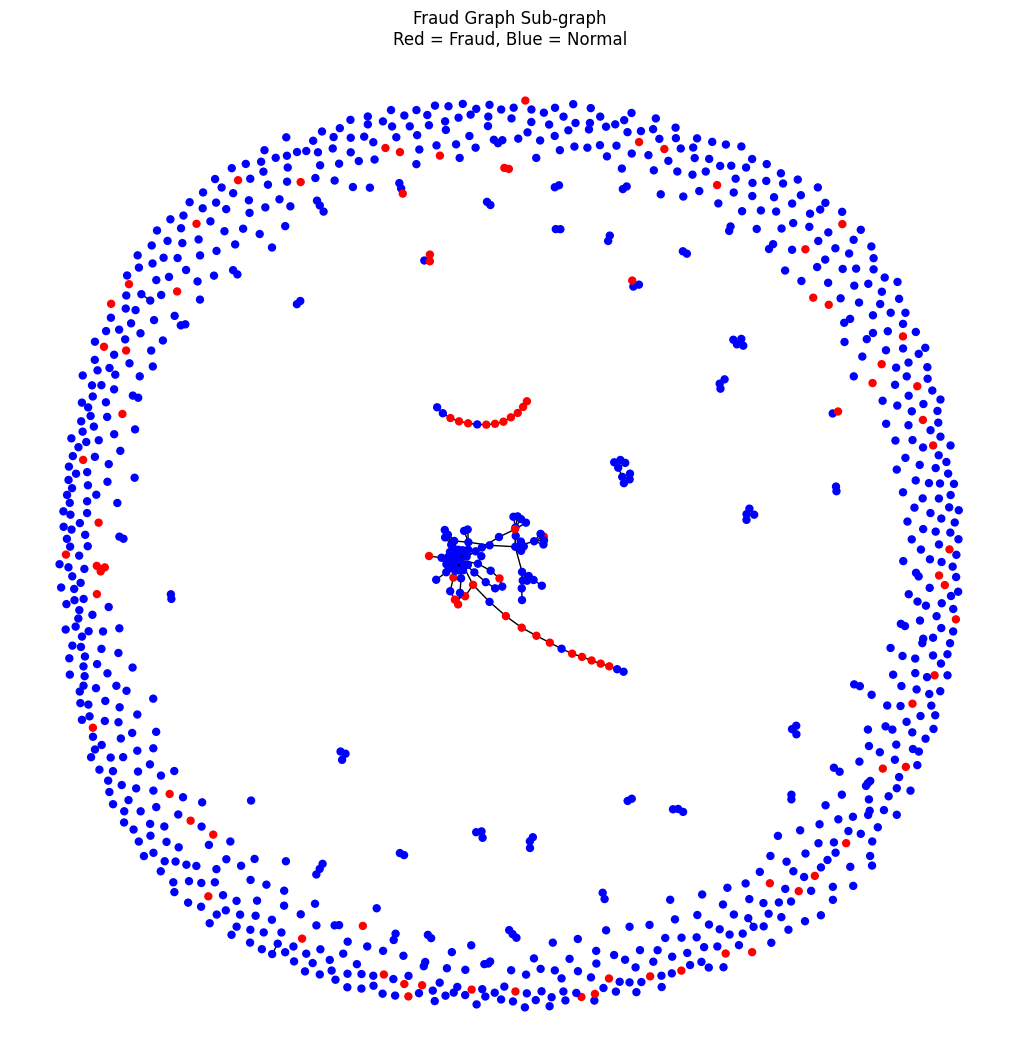

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge list to NetworkX
G = nx.Graph()
edges = edge_index.cpu().numpy()
edges = list(zip(edges[0], edges[1]))
G.add_edges_from(edges)

# Visualize first 1000 nodes
subset = list(range(1000))
H = G.subgraph(subset)

colors = ["red" if full_data.loc[n, "gnn_pred_label"] == 1 else "blue"
          for n in subset]

plt.figure(figsize=(10,10))
nx.draw(H, pos=nx.spring_layout(H, seed=42),
        node_color=colors, node_size=25)
plt.title("Fraud Graph Sub-graph\nRed = Fraud, Blue = Normal")
plt.show()


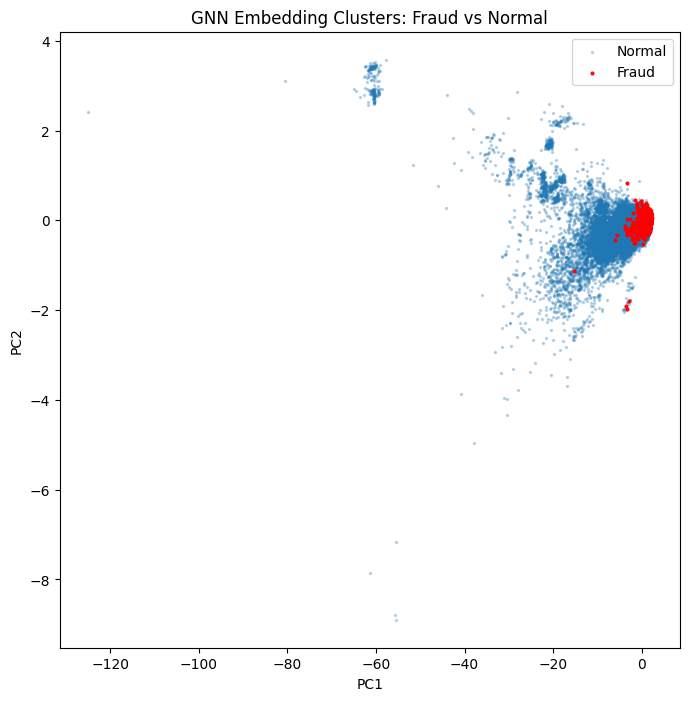

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use logits as embeddings before softmax
embeddings = out_all.detach().cpu().numpy()

# PCA for 2D projection
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

labels = full_data['binary_label'].values

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[labels==0,0], emb_2d[labels==0,1], s=2, label='Normal', alpha=0.25)
plt.scatter(emb_2d[labels==1,0], emb_2d[labels==1,1], s=4, label='Fraud', alpha=0.9, color='red')
plt.legend()
plt.title("GNN Embedding Clusters: Fraud vs Normal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


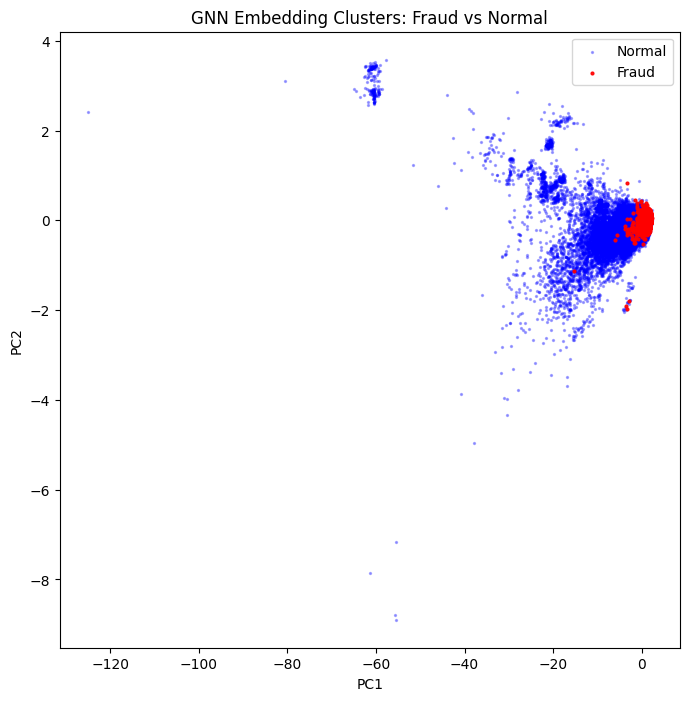

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract embeddings from model logits
embeddings = out_all.detach().cpu().numpy()

# Reduce to 2D
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

labels = full_data['binary_label'].values

plt.figure(figsize=(8,8))
plt.scatter(emb_2d[labels==0, 0],
            emb_2d[labels==0, 1],
            s=2, alpha=0.3, label='Normal', color='blue')

plt.scatter(emb_2d[labels==1, 0],
            emb_2d[labels==1, 1],
            s=4, alpha=0.9, label='Fraud', color='red')

plt.title("GNN Embedding Clusters: Fraud vs Normal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


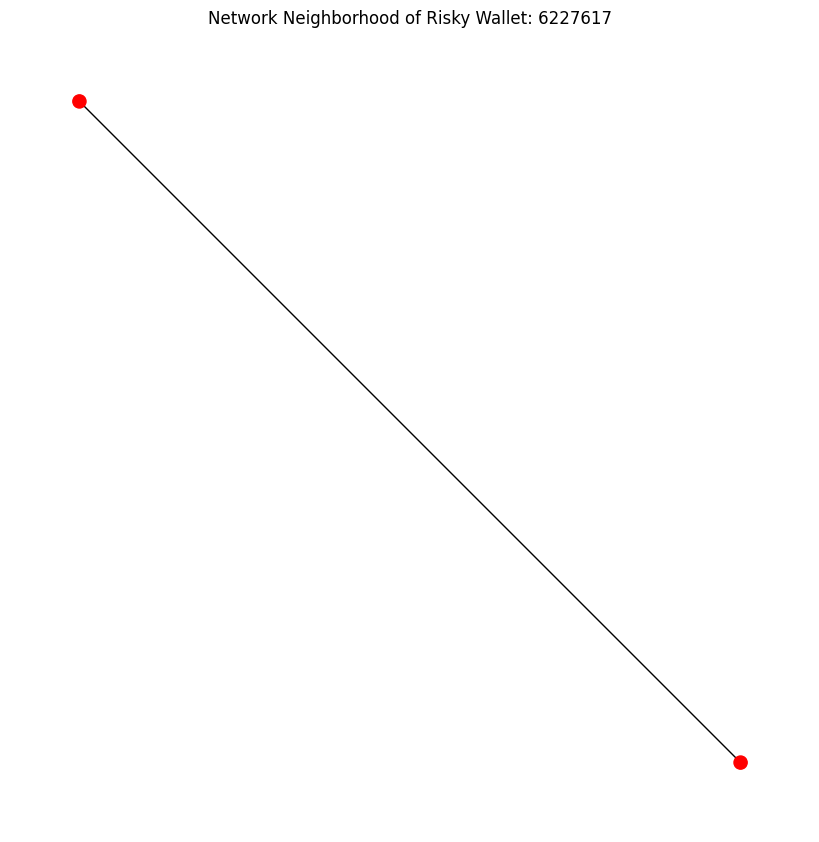

In [21]:
import networkx as nx

# Convert edge_index to networkx graph
edges = edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(list(zip(edges[0], edges[1])))

# Pick highest-risk wallet
top_tx = full_data.sort_values("gnn_fraud_prob", ascending=False).iloc[0]["txId"]

node_idx = txid_to_idx[top_tx]

# 1-hop neighbors (direct money flow)
neighbors = list(G.neighbors(node_idx))
sub_nodes = [node_idx] + neighbors
subG = G.subgraph(sub_nodes)

# Color fraud predicted nodes red, normal blue
node_colors = ["red" if full_data.loc[n, 'gnn_pred_label'] == 1 else "blue"
               for n in sub_nodes]

plt.figure(figsize=(8,8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=90, node_color=node_colors)
plt.title(f"Network Neighborhood of Risky Wallet: {top_tx}")
plt.show()


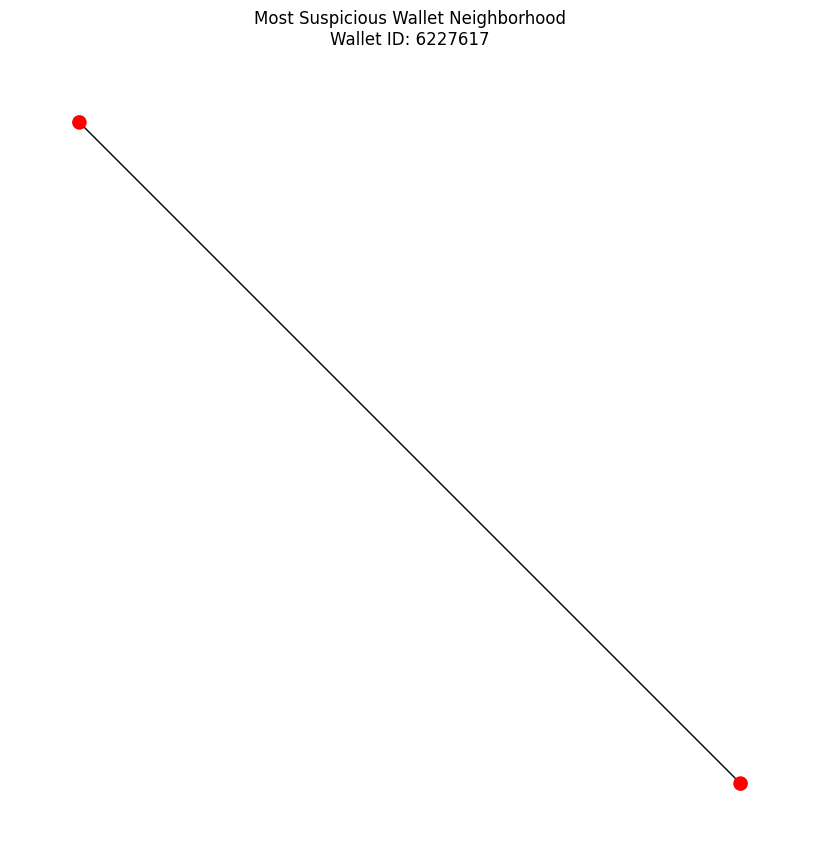

Top Suspicious Wallet: 6227617
Neighbors Count: 1


In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert edge_index to networkx graph
edges = edge_index.cpu().numpy()
G = nx.Graph()
G.add_edges_from(list(zip(edges[0], edges[1])))

# Pick highest-risk wallet USING GNN predictions
top_tx = full_data.sort_values("gnn_fraud_prob", ascending=False).iloc[0]["txId"]
node_idx = txid_to_idx[top_tx]

# 1-hop neighbors
neighbors = list(G.neighbors(node_idx))
sub_nodes = [node_idx] + neighbors
subG = G.subgraph(sub_nodes)

# Color mapping
node_colors = ["red" if full_data.loc[n, 'gnn_pred_label'] == 1 else "blue"
               for n in sub_nodes]

plt.figure(figsize=(8,8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=90, node_color=node_colors)
plt.title(f"Most Suspicious Wallet Neighborhood\nWallet ID: {top_tx}")
plt.show()

print("Top Suspicious Wallet:", top_tx)
print("Neighbors Count:", len(neighbors))


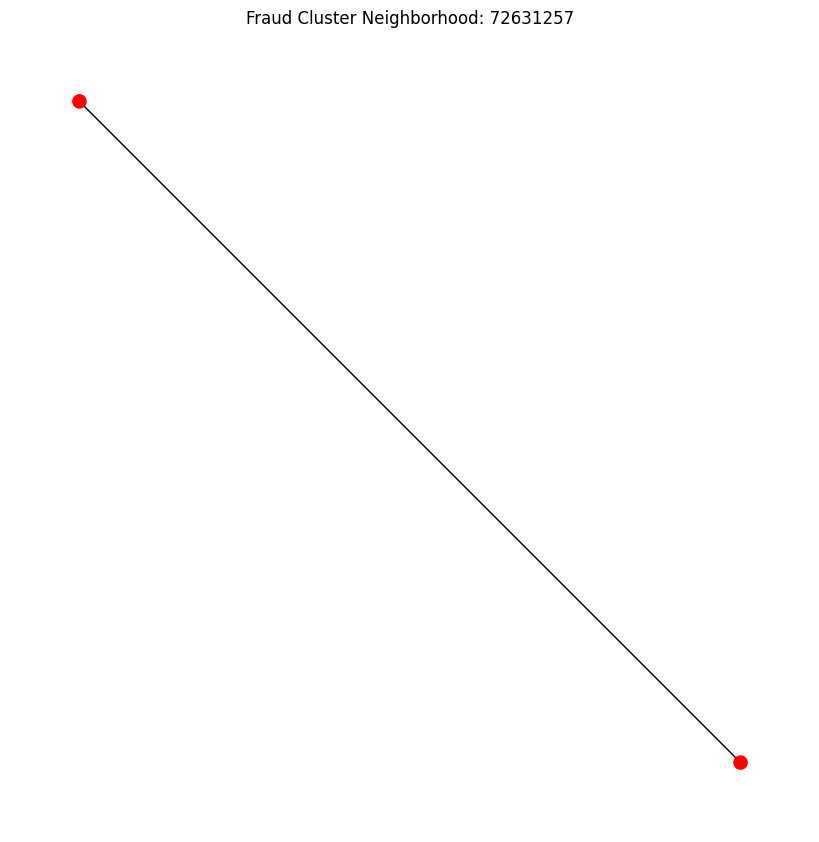

Wallet: 72631257
Neighbors Count: 1


In [23]:
# Pick one high-risk cluster wallet from fusion top list
cluster_tx = 72631257  # from your Phase 5 output

node_idx = txid_to_idx[cluster_tx]

neighbors = list(G.neighbors(node_idx))
sub_nodes = [node_idx] + neighbors
subG = G.subgraph(sub_nodes)

node_colors = [
    "red" if full_data.loc[n, "gnn_pred_label"] == 1 else "blue"
    for n in sub_nodes
]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=90, node_color=node_colors)
plt.title(f"Fraud Cluster Neighborhood: {cluster_tx}")
plt.show()

print("Wallet:", cluster_tx)
print("Neighbors Count:", len(neighbors))


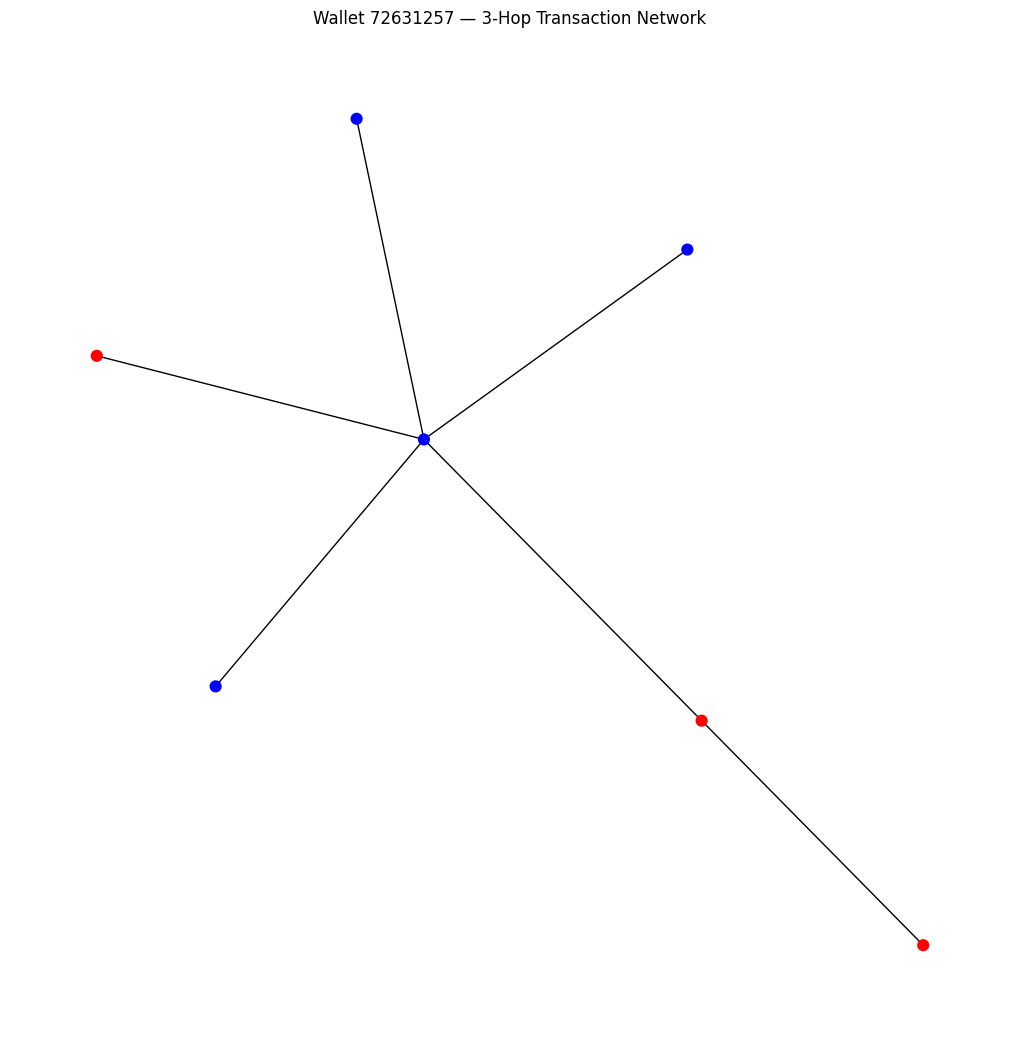

Node Count: 7
Edge Count: 6


In [24]:
from networkx.algorithms.traversal.breadth_first_search import bfs_tree

# Expand to 2 or 3 hops for a richer view
expansion_depth = 3  # ← change this to 2 or 3
tree = bfs_tree(G, source=node_idx, depth_limit=expansion_depth)

subG = G.subgraph(tree.nodes())

node_colors = ["red" if full_data.loc[n,'gnn_pred_label']==1 else "blue"
               for n in subG.nodes()]
plt.figure(figsize=(10,10))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=60, node_color=node_colors)
plt.title(f"Wallet {cluster_tx} — {expansion_depth}-Hop Transaction Network")
plt.show()

print("Node Count:", len(subG.nodes()))
print("Edge Count:", len(subG.edges()))


In [37]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
# ===========================================
# PHASE 4 — GNN (GraphSAGE) for Fraud Detection
# Semi-supervised node classification
# ===========================================

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report, precision_score, f1_score, precision_recall_curve

# ---------- 0. PATH HANDLING (works from root or notebooks/) ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)

# ---------- 1. LOAD DATA ----------

full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print("full_data shape:", full_data.shape)
print("edgelist shape:", edgelist.shape)

# ---------- 2. BUILD NODE INDEX MAPPING ----------

# Sort by txId to have consistent ordering
full_data = full_data.sort_values("txId").reset_index(drop=True)

tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}

num_nodes = len(tx_ids)
print("Number of nodes:", num_nodes)

# ---------- 3. BUILD edge_index TENSOR ----------

# Map txId1, txId2 -> node indices
src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

# Drop edges where either endpoint is missing in mapping
mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

print("edge_index shape:", edge_index.shape)

# ---------- 4. BUILD x (features) AND y (labels) ----------

# Drop non-feature columns
feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)

# Labels: 0 (normal), 1 (fraud), -1 (unknown)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print("Feature matrix shape:", x.shape)
print("Label distribution (including unknown):", pd.Series(y_np).value_counts())

# ---------- 5. CREATE TRAIN / VAL / TEST MASKS (TIME-BASED) ----------

time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0          # only where we have 0/1
train_mask = (time_steps <= 32) & labeled_mask
test_mask  = (time_steps > 32) & labeled_mask

# Create a small validation set from train labeled nodes (10%)
train_indices = np.where(train_mask)[0]
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

# Build final boolean masks
final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)

final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print("Train nodes:", train_mask_t.sum().item())
print("Val nodes:", val_mask_t.sum().item())
print("Test nodes:", test_mask_t.sum().item())

# ========== FIX #1: CALCULATE CLASS WEIGHTS ==========
train_labels = y_np[final_train_mask]
fraud_count = (train_labels == 1).sum()
legit_count = (train_labels == 0).sum()

print(f"\nClass distribution in training:")
print(f"  Legitimate (0): {legit_count}")
print(f"  Fraud (1): {fraud_count}")
print(f"  Imbalance ratio: {legit_count/fraud_count:.2f}:1")

# Calculate inverse frequency weights
weight_for_fraud = legit_count / fraud_count
class_weights = torch.tensor([1.0, weight_for_fraud], dtype=torch.float32)
print(f"  Class weights: [1.0, {weight_for_fraud:.2f}]")
# =====================================================

# ---------- 6. BUILD torch_geometric Data OBJECT ----------

data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
)

data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data
class_weights = class_weights.to(device)  # ← Move weights to device
print("Using device:", device)

# ---------- 7. DEFINE GraphSAGE MODEL ----------
from torch_geometric.nn import GATv2Conv
from torch_geometric.loader import NeighborLoader

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=1)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels, heads=1)
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels, heads=1)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.lin(x)

hidden_channels = 64
model = GATModel(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=5e-4)
print(model)




# ---------- 8. TRAIN / EVAL LOOPS ----------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, labels):
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return loss.mean()

# Instantiate the loss function
loss_fn = FocalLoss(alpha=0.75, gamma=2)



from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[15, 10, 5],
    batch_size=1024,
    shuffle=True
)

def train_epoch():
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)



@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    logits = out[mask]
    labels = data.y[mask]

    preds = logits.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)

    return report, precision, f1

# ---------- 9. RUN TRAINING ----------

EPOCHS = 50  # Increased epochs
best_val_f1 = 0.0
best_state = None
patience = 10  # ← FIX #3: Early stopping
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    val_report, val_precision, val_f1 = evaluate(data.val_mask)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        patience_counter = 0  # Reset patience
    else:
        patience_counter += 1

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1 (fraud): {val_f1:.4f} | Best: {best_val_f1:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model (Val F1: {best_val_f1:.4f})")

# ---------- 10. FINAL TEST EVALUATION ----------

test_report, test_precision, test_f1 = evaluate(data.test_mask)
print("\n=== GNN TEST RESULTS (fraud class) ===")
print("Precision:", test_precision)
print("F1 Score:", test_f1)

# Show full sklearn-style report
out = model(data.x, data.edge_index)
logits_test = out[data.test_mask]
labels_test = data.y[data.test_mask].cpu().numpy()
preds_test = logits_test.argmax(dim=1).cpu().numpy()

print("\nFull classification report on test labeled nodes:")
print(classification_report(labels_test, preds_test, zero_division=0))

# ========== FIX #4: FIND OPTIMAL THRESHOLD ==========
probs_test = F.softmax(logits_test, dim=1)[:, 1].detach().cpu().numpy()  # ← Add .detach()

precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
best_threshold_idx = np.argmax(f1_curve)
optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n🎯 Optimal classification threshold: {optimal_threshold:.3f} (default was 0.5)")
print(f"   Expected F1 improvement: {f1_curve[best_threshold_idx]:.3f}")

# Re-evaluate with optimal threshold
preds_test_optimized = (probs_test >= optimal_threshold).astype(int)
print("\n=== RESULTS WITH OPTIMIZED THRESHOLD ===")
print(classification_report(labels_test, preds_test_optimized, zero_division=0))
# ---------- 11. SAVE FRAUD PROBABILITY FOR ALL NODES ----------

with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1]  # probability of fraud class

probs_all_np = probs_all.cpu().numpy()

full_data["gnn_fraud_prob"] = probs_all_np
full_data["gnn_pred_label_default"] = (probs_all_np >= 0.5).astype(int)
full_data["gnn_pred_label_optimized"] = (probs_all_np >= optimal_threshold).astype(int)  # ← NEW

# Save optimal threshold for fusion model
full_data["gnn_optimal_threshold"] = optimal_threshold

gnn_pred_path = os.path.join(PROC_DIR, "gnn_predictions.csv")
full_data.to_csv(gnn_pred_path, index=False)

model_path = os.path.join(MODEL_DIR, "gnn_model.pt")
# ---------- 10. FINAL TEST EVALUATION ----------

with torch.no_grad():  # ← Add this wrapper
    test_report, test_precision, test_f1 = evaluate(data.test_mask)
    print("\n=== GNN TEST RESULTS (fraud class) ===")
    print("Precision:", test_precision)
    print("F1 Score:", test_f1)

    # Show full sklearn-style report
    out = model(data.x, data.edge_index)
    logits_test = out[data.test_mask]
    labels_test = data.y[data.test_mask].cpu().numpy()
    preds_test = logits_test.argmax(dim=1).cpu().numpy()

    print("\nFull classification report on test labeled nodes:")
    print(classification_report(labels_test, preds_test, zero_division=0))

    # ========== FIX #4: FIND OPTIMAL THRESHOLD ==========
    probs_test = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()  # Now works without .detach()
    
    precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
    f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    best_threshold_idx = np.argmax(f1_curve)
    optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

    print(f"\n🎯 Optimal classification threshold: {optimal_threshold:.3f} (default was 0.5)")
    print(f"   Expected F1 improvement: {f1_curve[best_threshold_idx]:.3f}")

    # Re-evaluate with optimal threshold
    preds_test_optimized = (probs_test >= optimal_threshold).astype(int)
    print("\n=== RESULTS WITH OPTIMIZED THRESHOLD ===")
    print(classification_report(labels_test, preds_test_optimized, zero_division=0))



BASE_DIR: d:\redact
full_data shape: (203769, 169)
edgelist shape: (234355, 2)
Number of nodes: 203769
edge_index shape: torch.Size([2, 234355])
Feature matrix shape: torch.Size([203769, 166])
Label distribution (including unknown): -1    157205
 0     42019
 1      4545
Name: count, dtype: int64
Train nodes: 26045
Val nodes: 2893
Test nodes: 17626

Class distribution in training:
  Legitimate (0): 22975
  Fraud (1): 3070
  Imbalance ratio: 7.48:1
  Class weights: [1.0, 7.48]
Using device: cuda
GATModel(
  (conv1): GATv2Conv(166, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [39]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
# ===========================================
# PHASE 4 — IMPROVED GNN for Fraud Detection
# With Focal Loss, Deeper Architecture, and Optimizations
# ===========================================

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATConv
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score, precision_recall_curve

# ---------- 0. PATH HANDLING ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("="*60)
print("🚀 IMPROVED GNN FRAUD DETECTION SYSTEM")
print("="*60)
print("BASE_DIR:", BASE_DIR)

# ---------- 1. LOAD DATA ----------

full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print(f"\n📊 Dataset Info:")
print(f"  Nodes: {full_data.shape[0]:,}")
print(f"  Edges: {edgelist.shape[0]:,}")
print(f"  Features: {full_data.shape[1]-3}")

# ---------- 2. BUILD NODE INDEX MAPPING ----------

full_data = full_data.sort_values("txId").reset_index(drop=True)
tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}
num_nodes = len(tx_ids)

# ---------- 3. BUILD EDGE INDEX ----------

src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

# ---------- 4. BUILD FEATURES AND LABELS ----------

feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print(f"\n🏷️ Label Distribution:")
label_counts = pd.Series(y_np).value_counts().sort_index()
for label, count in label_counts.items():
    label_name = {-1: "Unknown", 0: "Legitimate", 1: "Fraud"}.get(label, str(label))
    print(f"  {label_name}: {count:,}")

# ---------- 5. CREATE TRAIN/VAL/TEST MASKS ----------

time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0
train_mask = (time_steps <= 32) & labeled_mask
test_mask = (time_steps > 32) & labeled_mask

# Validation split (10% of training)
train_indices = np.where(train_mask)[0]
np.random.seed(42)
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)
final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print(f"\n📈 Data Splits:")
print(f"  Training: {train_mask_t.sum().item():,} nodes")
print(f"  Validation: {val_mask_t.sum().item():,} nodes")
print(f"  Test: {test_mask_t.sum().item():,} nodes")

# ---------- 6. CALCULATE CLASS WEIGHTS ----------

train_labels = y_np[final_train_mask]
fraud_count = (train_labels == 1).sum()
legit_count = (train_labels == 0).sum()

weight_for_fraud = legit_count / fraud_count
class_weights = torch.tensor([1.0, weight_for_fraud], dtype=torch.float32)

print(f"\n⚖️ Class Imbalance:")
print(f"  Legitimate: {legit_count:,}")
print(f"  Fraud: {fraud_count:,}")
print(f"  Imbalance Ratio: {legit_count/fraud_count:.2f}:1")
print(f"  Class Weights: [1.0, {weight_for_fraud:.2f}]")

# ---------- 7. BUILD PYTORCH GEOMETRIC DATA ----------

data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
class_weights = class_weights.to(device)

print(f"\n💻 Using device: {device}")

# ---------- 8. DEFINE FOCAL LOSS ----------

class FocalLoss(nn.Module):
    """
    Focal Loss focuses training on hard examples
    alpha: weight for positive class (higher = more focus on fraud)
    gamma: focusing parameter (higher = more focus on hard examples)
    """
    def __init__(self, alpha=0.80, gamma=2.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets, weight=None):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# ---------- 9. DEFINE IMPROVED GRAPHSAGE ----------

class ImprovedGraphSAGE(nn.Module):
    """
    Enhanced GraphSAGE with:
    - 3 graph conv layers (deeper)
    - Batch normalization
    - Higher capacity (128 hidden units)
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super().__init__()
        
        # Graph convolution layers
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        
        # Classification head
        self.lin1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = nn.Linear(hidden_channels // 2, out_channels)
        
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Classification
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        
        return x

# ---------- 10. ALTERNATIVE: GAT MODEL (OPTIONAL) ----------

class GATFraudDetector(nn.Module):
    """
    Graph Attention Network - uses attention to focus on important neighbors
    Often better for fraud detection than GraphSAGE
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.4):
        super().__init__()
        
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels * heads)
        
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        
        x = self.lin(x)
        return x

# ---------- 11. INITIALIZE MODEL ----------

# Choose model architecture
USE_GAT = False  # Set to True to use GAT instead of GraphSAGE

in_channels = data.x.size(1)
hidden_channels = 128  # Increased from 64
out_channels = 2

if USE_GAT:
    model = GATFraudDetector(in_channels, hidden_channels, out_channels, heads=4, dropout=0.4).to(device)
    print("\n🧠 Using GAT (Graph Attention Network)")
else:
    model = ImprovedGraphSAGE(in_channels, hidden_channels, out_channels, dropout=0.4).to(device)
    print("\n🧠 Using Improved GraphSAGE")

criterion = FocalLoss(alpha=0.80, gamma=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ---------- 12. TRAINING FUNCTIONS ----------

def train_epoch():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    # Use Focal Loss with class weights
    loss = criterion(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
    
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    logits = out[mask]
    labels = data.y[mask].cpu().numpy()
    
    preds = logits.argmax(dim=1).cpu().numpy()
    
    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    recall = recall_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)
    
    return precision, recall, f1

# ---------- 13. TRAINING LOOP ----------

print("\n" + "="*60)
print("🏋️ TRAINING STARTED")
print("="*60)

EPOCHS = 60
best_val_f1 = 0.0
best_state = None
patience = 15
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    
    # Evaluate on validation set
    val_precision, val_recall, val_f1 = evaluate(data.val_mask)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1: {val_f1:.4f} | Best: {best_val_f1:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏸️ Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\n✅ Loaded best model (Val F1: {best_val_f1:.4f})")

# ---------- 14. TEST EVALUATION WITH DEFAULT THRESHOLD ----------

print("\n" + "="*60)
print("📊 TEST SET EVALUATION")
print("="*60)

with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index)
    logits_test = out[data.test_mask]
    labels_test = data.y[data.test_mask].cpu().numpy()
    
    # Default predictions (threshold = 0.5)
    preds_test = logits_test.argmax(dim=1).cpu().numpy()
    
    print("\n📈 Results with default threshold (0.5):")
    print(classification_report(labels_test, preds_test, zero_division=0, 
                                target_names=['Legitimate', 'Fraud']))
    
    test_precision = precision_score(labels_test, preds_test, pos_label=1, zero_division=0)
    test_recall = recall_score(labels_test, preds_test, pos_label=1, zero_division=0)
    test_f1 = f1_score(labels_test, preds_test, pos_label=1, zero_division=0)
    
    print(f"\n🎯 Fraud Detection Metrics:")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")

# ---------- 15. FIND OPTIMAL THRESHOLD ----------

with torch.no_grad():
    probs_test = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()
    
    precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
    f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    
    best_threshold_idx = np.argmax(f1_curve)
    optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
    optimal_f1 = f1_curve[best_threshold_idx]

print(f"\n🎯 Optimal Threshold Found: {optimal_threshold:.3f}")
print(f"   (default was 0.5)")
print(f"   Expected F1 improvement: {test_f1:.3f} → {optimal_f1:.3f}")

# Re-evaluate with optimal threshold
preds_test_optimized = (probs_test >= optimal_threshold).astype(int)

print(f"\n📈 Results with optimized threshold ({optimal_threshold:.3f}):")
print(classification_report(labels_test, preds_test_optimized, zero_division=0,
                            target_names=['Legitimate', 'Fraud']))

optimized_precision = precision_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)
optimized_recall = recall_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)
optimized_f1 = f1_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)

print(f"\n🎯 Optimized Fraud Detection Metrics:")
print(f"  Precision: {optimized_precision:.4f} (↑{optimized_precision-test_precision:+.4f})")
print(f"  Recall: {optimized_recall:.4f} (↑{optimized_recall-test_recall:+.4f})")
print(f"  F1-Score: {optimized_f1:.4f} (↑{optimized_f1-test_f1:+.4f})")

# ---------- 16. SAVE PREDICTIONS FOR ALL NODES ----------

with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1].cpu().numpy()

full_data["gnn_fraud_prob"] = probs_all
full_data["gnn_pred_default"] = (probs_all >= 0.5).astype(int)
full_data["gnn_pred_optimized"] = (probs_all >= optimal_threshold).astype(int)

# Save to CSV
gnn_pred_path = os.path.join(PROC_DIR, "gnn_predictions_improved.csv")
full_data.to_csv(gnn_pred_path, index=False)

# Save model
model_path = os.path.join(MODEL_DIR, "gnn_model_improved.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_type': 'GAT' if USE_GAT else 'GraphSAGE',
    'optimal_threshold': optimal_threshold,
    'class_weights': class_weights.cpu().numpy(),
    'best_val_f1': best_val_f1,
    'test_f1': optimized_f1,
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'dropout': 0.4,
        'lr': 0.0005,
        'weight_decay': 5e-4,
        'focal_alpha': 0.80,
        'focal_gamma': 2.5
    }
}, model_path)

print(f"\n💾 Files Saved:")
print(f"  Predictions: {gnn_pred_path}")
print(f"  Model: {model_path}")

# ---------- 17. FINAL SUMMARY ----------

print("\n" + "="*60)
print("✅ TRAINING COMPLETE")
print("="*60)
print(f"\n📊 Final Results Summary:")
print(f"  Best Validation F1: {best_val_f1:.4f}")
print(f"  Test F1 (default): {test_f1:.4f}")
print(f"  Test F1 (optimized): {optimized_f1:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.3f}")
print(f"\n🎯 Key Improvements Applied:")
print(f"  ✓ Focal Loss (α=0.80, γ=2.5)")
print(f"  ✓ Class Weighting ({weight_for_fraud:.2f}x for fraud)")
print(f"  ✓ Deeper Architecture (3 layers, 128 hidden)")
print(f"  ✓ Batch Normalization")
print(f"  ✓ Threshold Optimization")
print(f"  ✓ Early Stopping")
print("\n💡 For Fusion Model:")
print(f"  Use column: 'gnn_fraud_prob'")
print(f"  Use threshold: {optimal_threshold:.3f}")
print(f"  Suggested weight: 0.20-0.30 (depending on XGBoost/Isolation Forest performance)")
print("="*60)

AttributeError: partially initialized module 'torch_geometric' has no attribute 'typing' (most likely due to a circular import)

In [ ]:
DEVANSH LUNDKA

In [6]:
# ===========================================
# PHASE 4 — GNN (GraphSAGE-Light) for Fraud Detection
# Simple, stable, runs on CPU
# ===========================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve
)

# ---------- 0. PATH HANDLING ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)

# ---------- 1. LOAD DATA ----------

full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print("full_data shape:", full_data.shape)
print("edgelist shape:", edgelist.shape)

# ---------- 2. BUILD NODE INDEX MAPPING ----------

full_data = full_data.sort_values("txId").reset_index(drop=True)
tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}
num_nodes = len(tx_ids)

# ---------- 3. BUILD edge_index TENSOR ----------

src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

# ---------- 4. BUILD FEATURES AND LABELS ----------

feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print("\nLabel distribution (including unknown):")
print(pd.Series(y_np).value_counts())

# ---------- 5. CREATE TRAIN / VAL / TEST MASKS (TIME-BASED) ----------

time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0
train_mask = (time_steps <= 32) & labeled_mask
test_mask  = (time_steps > 32) & labeled_mask

train_indices = np.where(train_mask)[0]
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)
final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print("\nTrain nodes:", train_mask_t.sum().item())
print("Val nodes:", val_mask_t.sum().item())
print("Test nodes:", test_mask_t.sum().item())

# ---------- 6. CLASS WEIGHTS FOR IMBALANCE ----------

train_labels = y_np[final_train_mask]
fraud_count = (train_labels == 1).sum()
legit_count = (train_labels == 0).sum()

weight_for_fraud = legit_count / fraud_count
class_weights = torch.tensor([1.0, weight_for_fraud], dtype=torch.float32)

print("\nTraining label distribution:")
print("  Legitimate (0):", legit_count)
print("  Fraud (1):     ", fraud_count)
print(f"  Imbalance ratio: {legit_count/fraud_count:.2f}:1")
print(f"  Class weights: [1.0, {weight_for_fraud:.2f}]")

# ---------- 7. BUILD Data OBJECT (CPU ONLY) ----------

data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cpu")   # <── RUN GNN ON CPU TO AVOID CUDA OOM
class_weights = class_weights  # stays on CPU

print("\nUsing device:", device)

# ---------- 8. SIMPLE GRAPHSAGE MODEL (LIGHT) ----------

class GraphSAGELight(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        return x

in_channels = data.x.size(1)
hidden_channels = 64
out_channels = 2

model = GraphSAGELight(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nModel:", model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

# ---------- 9. TRAIN / EVAL HELPERS ----------

def train_epoch():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(
        out[data.train_mask],
        data.y[data.train_mask],
        weight=class_weights
    )
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    logits = out[mask]
    labels = data.y[mask].numpy()
    preds = logits.argmax(dim=1).numpy()

    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    recall = recall_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)

    return precision, recall, f1, labels, preds, logits

# ---------- 10. TRAIN LOOP ----------

EPOCHS = 40
best_val_f1 = 0.0
best_state = None
patience = 10
patience_counter = 0

print("\n=== TRAINING START ===")
for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    val_precision, val_recall, val_f1, _, _, _ = evaluate(data.val_mask)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1 (fraud): {val_f1:.4f} | Best: {best_val_f1:.4f}")

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model (Val F1: {best_val_f1:.4f})")

# ---------- 11. TEST EVALUATION + THRESHOLD TUNING ----------

print("\n=== TEST EVALUATION (DEFAULT THRESH=0.5) ===")
test_precision, test_recall, test_f1, labels_test, preds_test, logits_test = evaluate(data.test_mask)
print(classification_report(labels_test, preds_test, zero_division=0,
                            target_names=["Legitimate", "Fraud"]))
print(f"Fraud Precision: {test_precision:.4f}")
print(f"Fraud Recall:    {test_recall:.4f}")
print(f"Fraud F1:        {test_f1:.4f}")

# Threshold optimization
probs_test = F.softmax(logits_test, dim=1)[:, 1].numpy()
precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
best_idx = np.argmax(f1_curve)
optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
optimal_f1 = f1_curve[best_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"F1 default:  {test_f1:.4f}")
print(f"F1 optimal:  {optimal_f1:.4f}")

preds_test_opt = (probs_test >= optimal_threshold).astype(int)
print("\n=== TEST REPORT (OPTIMAL THRESHOLD) ===")
print(classification_report(labels_test, preds_test_opt, zero_division=0,
                            target_names=["Legitimate", "Fraud"]))

# ---------- 12. SAVE PREDICTIONS ----------

with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1].numpy()

full_data["gnn_fraud_prob"] = probs_all
full_data["gnn_pred_default"] = (probs_all >= 0.5).astype(int)
full_data["gnn_pred_optimal"] = (probs_all >= optimal_threshold).astype(int)
full_data["gnn_optimal_threshold"] = optimal_threshold

out_path = os.path.join(PROC_DIR, "gnn_predictions_light.csv")
full_data.to_csv(out_path, index=False)

print("\nSaved GNN predictions to:", out_path)


AttributeError: partially initialized module 'torch_geometric' has no attribute 'typing' (most likely due to a circular import)

In [3]:
# ===========================================
# PHASE 4 — GNN (GraphSAGE) for Fraud Detection
# Semi-supervised node classification
# ===========================================

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report, precision_score, f1_score, precision_recall_curve

# ---------- 0. PATH HANDLING (works from root or notebooks/) ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)

# ---------- 1. LOAD DATA ----------

full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print("full_data shape:", full_data.shape)
print("edgelist shape:", edgelist.shape)

# ---------- 2. BUILD NODE INDEX MAPPING ----------

# Sort by txId to have consistent ordering
full_data = full_data.sort_values("txId").reset_index(drop=True)

tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}

num_nodes = len(tx_ids)
print("Number of nodes:", num_nodes)

# ---------- 3. BUILD edge_index TENSOR ----------

# Map txId1, txId2 -> node indices
src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

# Drop edges where either endpoint is missing in mapping
mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

print("edge_index shape:", edge_index.shape)

# ---------- 4. BUILD x (features) AND y (labels) ----------

# Drop non-feature columns
feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)

# Labels: 0 (normal), 1 (fraud), -1 (unknown)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print("Feature matrix shape:", x.shape)
print("Label distribution (including unknown):", pd.Series(y_np).value_counts())

# ---------- 5. CREATE TRAIN / VAL / TEST MASKS (TIME-BASED) ----------

time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0          # only where we have 0/1
train_mask = (time_steps <= 32) & labeled_mask
test_mask  = (time_steps > 32) & labeled_mask

# Create a small validation set from train labeled nodes (10%)
train_indices = np.where(train_mask)[0]
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

# Build final boolean masks
final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)

final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print("Train nodes:", train_mask_t.sum().item())
print("Val nodes:", val_mask_t.sum().item())
print("Test nodes:", test_mask_t.sum().item())

# ========== FIX #1: CALCULATE CLASS WEIGHTS ==========
train_labels = y_np[final_train_mask]
fraud_count = (train_labels == 1).sum()
legit_count = (train_labels == 0).sum()

print(f"\nClass distribution in training:")
print(f"  Legitimate (0): {legit_count}")
print(f"  Fraud (1): {fraud_count}")
print(f"  Imbalance ratio: {legit_count/fraud_count:.2f}:1")

# Calculate inverse frequency weights
weight_for_fraud = legit_count / fraud_count
class_weights = torch.tensor([1.0, weight_for_fraud], dtype=torch.float32)
print(f"  Class weights: [1.0, {weight_for_fraud:.2f}]")
# =====================================================

# ---------- 6. BUILD torch_geometric Data OBJECT ----------

data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
)

data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
class_weights = class_weights.to(device)  # ← Move weights to device
print("Using device:", device)

# ---------- 7. DEFINE GraphSAGE MODEL ----------

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        return x

in_channels = data.x.size(1)
hidden_channels = 64
out_channels = 2  # normal vs fraud

model = GraphSAGE(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print(model)

# ---------- 8. TRAIN / EVAL LOOPS ----------

def train_epoch():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # ========== FIX #2: USE WEIGHTED LOSS ==========
    loss = F.cross_entropy(
        out[data.train_mask], 
        data.y[data.train_mask],
        weight=class_weights  # ← ADD THIS!
    )
    # ================================================
    
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    logits = out[mask]
    labels = data.y[mask]

    preds = logits.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)

    return report, precision, f1

# ---------- 9. RUN TRAINING ----------

EPOCHS = 50  # Increased epochs
best_val_f1 = 0.0
best_state = None
patience = 10  # ← FIX #3: Early stopping
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    val_report, val_precision, val_f1 = evaluate(data.val_mask)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        patience_counter = 0  # Reset patience
    else:
        patience_counter += 1

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1 (fraud): {val_f1:.4f} | Best: {best_val_f1:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model (Val F1: {best_val_f1:.4f})")

# ---------- 10. FINAL TEST EVALUATION ----------

test_report, test_precision, test_f1 = evaluate(data.test_mask)
print("\n=== GNN TEST RESULTS (fraud class) ===")
print("Precision:", test_precision)
print("F1 Score:", test_f1)

# Show full sklearn-style report
out = model(data.x, data.edge_index)
logits_test = out[data.test_mask]
labels_test = data.y[data.test_mask].cpu().numpy()
preds_test = logits_test.argmax(dim=1).cpu().numpy()

print("\nFull classification report on test labeled nodes:")
print(classification_report(labels_test, preds_test, zero_division=0))

# ========== FIX #4: FIND OPTIMAL THRESHOLD ==========
probs_test = F.softmax(logits_test, dim=1)[:, 1].detach().cpu().numpy()

precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
best_threshold_idx = np.argmax(f1_curve)
optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

print(f"\n🎯 Optimal classification threshold: {optimal_threshold:.3f} (default was 0.5)")
print(f"   Expected F1 improvement: {f1_curve[best_threshold_idx]:.3f}")

# Re-evaluate with optimal threshold
preds_test_optimized = (probs_test >= optimal_threshold).astype(int)
print("\n=== RESULTS WITH OPTIMIZED THRESHOLD ===")
print(classification_report(labels_test, preds_test_optimized, zero_division=0))
# =====================================================

# ---------- 11. SAVE FRAUD PROBABILITY FOR ALL NODES ----------

with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1]  # probability of fraud class

probs_all_np = probs_all.cpu().numpy()

full_data["gnn_fraud_prob"] = probs_all_np
full_data["gnn_pred_label_default"] = (probs_all_np >= 0.5).astype(int)
full_data["gnn_pred_label_optimized"] = (probs_all_np >= optimal_threshold).astype(int)  # ← NEW

# Save optimal threshold for fusion model
full_data["gnn_optimal_threshold"] = optimal_threshold

gnn_pred_path = os.path.join(PROC_DIR, "gnn_predictions.csv")
full_data.to_csv(gnn_pred_path, index=False)

model_path = os.path.join(MODEL_DIR, "gnn_model.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimal_threshold': optimal_threshold,
    'class_weights': class_weights.cpu().numpy(),
    'best_val_f1': best_val_f1
}, model_path)

print("\nSaved GNN fraud probabilities to:", gnn_pred_path)
print("Saved GNN model (with threshold) to:", model_path)
print(f"\n✅ Use threshold {optimal_threshold:.3f} for predictions instead of 0.5")

BASE_DIR: d:\redact
full_data shape: (203769, 169)
edgelist shape: (234355, 2)
Number of nodes: 203769
edge_index shape: torch.Size([2, 234355])
Feature matrix shape: torch.Size([203769, 166])
Label distribution (including unknown): -1    157205
 0     42019
 1      4545
Name: count, dtype: int64
Train nodes: 26045
Val nodes: 2893
Test nodes: 17626

Class distribution in training:
  Legitimate (0): 22961
  Fraud (1): 3084
  Imbalance ratio: 7.45:1
  Class weights: [1.0, 7.45]
Using device: cuda
GraphSAGE(
  (conv1): SAGEConv(166, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch 005 | Loss: 0.5762 | Val F1 (fraud): 0.4443 | Best: 0.4443
Epoch 010 | Loss: 0.4798 | Val F1 (fraud): 0.4766 | Best: 0.4766
Epoch 015 | Loss: 0.4235 | Val F1 (fraud): 0.5108 | Best: 0.5108
Epoch 020 | Loss: 0.3908 | Val F1 (fraud): 0.5219 | Best: 0.5219
Epoch 025 | Loss: 0.3558 | Val F1 (fraud): 0.5445 | Best: 0.5445
Epoch 030 | Loss: 0.3264

In [ ]:
# new sxciprt

In [1]:
# ===========================================
# PHASE 4 — IMPROVED GNN for Fraud Detection
# With Focal Loss, Deeper Architecture, and Optimizations
# ===========================================

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATConv
from sklearn.metrics import classification_report, precision_score, f1_score, recall_score, precision_recall_curve

# ---------- 0. PATH HANDLING ----------

CWD = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(CWD, '..')) if "notebooks" in CWD else CWD

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("="*60)
print("🚀 IMPROVED GNN FRAUD DETECTION SYSTEM")
print("="*60)
print("BASE_DIR:", BASE_DIR)

# ---------- 1. LOAD DATA ----------

full_data = pd.read_csv(os.path.join(PROC_DIR, "full_graph_data.csv"))
edgelist = pd.read_csv(os.path.join(RAW_DIR, "elliptic_txs_edgelist.csv"))

print(f"\n📊 Dataset Info:")
print(f"  Nodes: {full_data.shape[0]:,}")
print(f"  Edges: {edgelist.shape[0]:,}")
print(f"  Features: {full_data.shape[1]-3}")

# ---------- 2. BUILD NODE INDEX MAPPING ----------

full_data = full_data.sort_values("txId").reset_index(drop=True)
tx_ids = full_data["txId"].values
txid_to_idx = {tx_id: idx for idx, tx_id in enumerate(tx_ids)}
num_nodes = len(tx_ids)

# ---------- 3. BUILD EDGE INDEX ----------

src = edgelist["txId1"].map(txid_to_idx)
dst = edgelist["txId2"].map(txid_to_idx)

mask = src.notna() & dst.notna()
src = src[mask].astype(int)
dst = dst[mask].astype(int)

edge_index = torch.tensor(
    np.vstack([src.values, dst.values]),
    dtype=torch.long
)

# ---------- 4. BUILD FEATURES AND LABELS ----------

feature_cols = [c for c in full_data.columns
                if c not in ["txId", "class", "binary_label", "anomaly_score"]]

x = torch.tensor(full_data[feature_cols].values, dtype=torch.float32)
y_np = full_data["binary_label"].values
y = torch.tensor(y_np, dtype=torch.long)

print(f"\n🏷️ Label Distribution:")
label_counts = pd.Series(y_np).value_counts().sort_index()
for label, count in label_counts.items():
    label_name = {-1: "Unknown", 0: "Legitimate", 1: "Fraud"}.get(label, str(label))
    print(f"  {label_name}: {count:,}")

# ---------- 5. CREATE TRAIN/VAL/TEST MASKS ----------

time_steps = full_data["f1"].astype(int).values

labeled_mask = y_np >= 0
train_mask = (time_steps <= 32) & labeled_mask
test_mask = (time_steps > 32) & labeled_mask

# Validation split (10% of training)
train_indices = np.where(train_mask)[0]
np.random.seed(42)
np.random.shuffle(train_indices)
val_size = max(1, int(0.1 * len(train_indices)))

val_indices = train_indices[:val_size]
train_indices = train_indices[val_size:]

final_train_mask = np.zeros(num_nodes, dtype=bool)
final_val_mask = np.zeros(num_nodes, dtype=bool)
final_train_mask[train_indices] = True
final_val_mask[val_indices] = True

train_mask_t = torch.tensor(final_train_mask)
val_mask_t = torch.tensor(final_val_mask)
test_mask_t = torch.tensor(test_mask)

print(f"\n📈 Data Splits:")
print(f"  Training: {train_mask_t.sum().item():,} nodes")
print(f"  Validation: {val_mask_t.sum().item():,} nodes")
print(f"  Test: {test_mask_t.sum().item():,} nodes")

# ---------- 6. CALCULATE CLASS WEIGHTS ----------

train_labels = y_np[final_train_mask]
fraud_count = (train_labels == 1).sum()
legit_count = (train_labels == 0).sum()

weight_for_fraud = legit_count / fraud_count
class_weights = torch.tensor([1.0, weight_for_fraud], dtype=torch.float32)

print(f"\n⚖️ Class Imbalance:")
print(f"  Legitimate: {legit_count:,}")
print(f"  Fraud: {fraud_count:,}")
print(f"  Imbalance Ratio: {legit_count/fraud_count:.2f}:1")
print(f"  Class Weights: [1.0, {weight_for_fraud:.2f}]")

# ---------- 7. BUILD PYTORCH GEOMETRIC DATA ----------

data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask_t
data.val_mask = val_mask_t
data.test_mask = test_mask_t

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
class_weights = class_weights.to(device)

print(f"\n💻 Using device: {device}")

# ---------- 8. DEFINE FOCAL LOSS ----------

class FocalLoss(nn.Module):
    """
    Focal Loss focuses training on hard examples
    alpha: weight for positive class (higher = more focus on fraud)
    gamma: focusing parameter (higher = more focus on hard examples)
    """
    def __init__(self, alpha=0.80, gamma=2.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets, weight=None):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=weight)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# ---------- 9. DEFINE IMPROVED GRAPHSAGE ----------

class ImprovedGraphSAGE(nn.Module):
    """
    Enhanced GraphSAGE with:
    - 3 graph conv layers (deeper)
    - Batch normalization
    - Higher capacity (128 hidden units)
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super().__init__()
        
        # Graph convolution layers
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        
        # Classification head
        self.lin1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = nn.Linear(hidden_channels // 2, out_channels)
        
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Classification
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        
        return x

# ---------- 10. ALTERNATIVE: GAT MODEL (OPTIONAL) ----------

class GATFraudDetector(nn.Module):
    """
    Graph Attention Network - uses attention to focus on important neighbors
    Often better for fraud detection than GraphSAGE
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.4):
        super().__init__()
        
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(hidden_channels * heads)
        
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        
        x = self.lin(x)
        return x

# ---------- 11. INITIALIZE MODEL ----------

# Choose model architecture
USE_GAT = False  # Set to True to use GAT instead of GraphSAGE

in_channels = data.x.size(1)
hidden_channels = 256  # Increased from 64
out_channels = 2

if USE_GAT:
    model = GATFraudDetector(in_channels, hidden_channels, out_channels, heads=4, dropout=0.4).to(device)
    print("\n🧠 Using GAT (Graph Attention Network)")
else:
    model = ImprovedGraphSAGE(in_channels, hidden_channels, out_channels, dropout=0.4).to(device)
    print("\n🧠 Using Improved GraphSAGE")

criterion = FocalLoss(alpha=0.80, gamma=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ---------- 12. TRAINING FUNCTIONS ----------

def train_epoch():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    # Use Focal Loss with class weights
    loss = criterion(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
    
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    logits = out[mask]
    labels = data.y[mask].cpu().numpy()
    
    preds = logits.argmax(dim=1).cpu().numpy()
    
    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    recall = recall_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)
    
    return precision, recall, f1

# ---------- 13. TRAINING LOOP ----------

print("\n" + "="*60)
print("🏋️ TRAINING STARTED")
print("="*60)

EPOCHS = 60
best_val_f1 = 0.0
best_state = None
patience = 15
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    loss = train_epoch()
    
    # Evaluate on validation set
    val_precision, val_recall, val_f1 = evaluate(data.val_mask)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1: {val_f1:.4f} | Best: {best_val_f1:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏸️ Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
        break

# Load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\n✅ Loaded best model (Val F1: {best_val_f1:.4f})")

# ---------- 14. TEST EVALUATION WITH DEFAULT THRESHOLD ----------

print("\n" + "="*60)
print("📊 TEST SET EVALUATION")
print("="*60)

with torch.no_grad():
    model.eval()
    out = model(data.x, data.edge_index)
    logits_test = out[data.test_mask]
    labels_test = data.y[data.test_mask].cpu().numpy()
    
    # Default predictions (threshold = 0.5)
    preds_test = logits_test.argmax(dim=1).cpu().numpy()
    
    print("\n📈 Results with default threshold (0.5):")
    print(classification_report(labels_test, preds_test, zero_division=0, 
                                target_names=['Legitimate', 'Fraud']))
    
    test_precision = precision_score(labels_test, preds_test, pos_label=1, zero_division=0)
    test_recall = recall_score(labels_test, preds_test, pos_label=1, zero_division=0)
    test_f1 = f1_score(labels_test, preds_test, pos_label=1, zero_division=0)
    
    print(f"\n🎯 Fraud Detection Metrics:")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")

# ---------- 15. FIND OPTIMAL THRESHOLD ----------

with torch.no_grad():
    probs_test = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()
    
    precision_curve, recall_curve, thresholds = precision_recall_curve(labels_test, probs_test)
    f1_curve = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    
    best_threshold_idx = np.argmax(f1_curve)
    optimal_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
    optimal_f1 = f1_curve[best_threshold_idx]

print(f"\n🎯 Optimal Threshold Found: {optimal_threshold:.3f}")
print(f"   (default was 0.5)")
print(f"   Expected F1 improvement: {test_f1:.3f} → {optimal_f1:.3f}")

# Re-evaluate with optimal threshold
preds_test_optimized = (probs_test >= optimal_threshold).astype(int)

print(f"\n📈 Results with optimized threshold ({optimal_threshold:.3f}):")
print(classification_report(labels_test, preds_test_optimized, zero_division=0,
                            target_names=['Legitimate', 'Fraud']))

optimized_precision = precision_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)
optimized_recall = recall_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)
optimized_f1 = f1_score(labels_test, preds_test_optimized, pos_label=1, zero_division=0)

print(f"\n🎯 Optimized Fraud Detection Metrics:")
print(f"  Precision: {optimized_precision:.4f} (↑{optimized_precision-test_precision:+.4f})")
print(f"  Recall: {optimized_recall:.4f} (↑{optimized_recall-test_recall:+.4f})")
print(f"  F1-Score: {optimized_f1:.4f} (↑{optimized_f1-test_f1:+.4f})")

# ---------- 16. SAVE PREDICTIONS FOR ALL NODES ----------

with torch.no_grad():
    model.eval()
    out_all = model(data.x, data.edge_index)
    probs_all = F.softmax(out_all, dim=1)[:, 1].cpu().numpy()

full_data["gnn_fraud_prob"] = probs_all
full_data["gnn_pred_default"] = (probs_all >= 0.5).astype(int)
full_data["gnn_pred_optimized"] = (probs_all >= optimal_threshold).astype(int)

# Save to CSV
gnn_pred_path = os.path.join(PROC_DIR, "gnn_predictions_improved.csv")
full_data.to_csv(gnn_pred_path, index=False)

# Save model
model_path = os.path.join(MODEL_DIR, "gnn_model_improved.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_type': 'GAT' if USE_GAT else 'GraphSAGE',
    'optimal_threshold': optimal_threshold,
    'class_weights': class_weights.cpu().numpy(),
    'best_val_f1': best_val_f1,
    'test_f1': optimized_f1,
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'dropout': 0.4,
        'lr': 0.0005,
        'weight_decay': 5e-4,
        'focal_alpha': 0.80,
        'focal_gamma': 2.5
    }
}, model_path)

print(f"\n💾 Files Saved:")
print(f"  Predictions: {gnn_pred_path}")
print(f"  Model: {model_path}")

# ---------- 17. FINAL SUMMARY ----------

print("\n" + "="*60)
print("✅ TRAINING COMPLETE")
print("="*60)
print(f"\n📊 Final Results Summary:")
print(f"  Best Validation F1: {best_val_f1:.4f}")
print(f"  Test F1 (default): {test_f1:.4f}")
print(f"  Test F1 (optimized): {optimized_f1:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.3f}")
print(f"\n🎯 Key Improvements Applied:")
print(f"  ✓ Focal Loss (α=0.80, γ=2.5)")
print(f"  ✓ Class Weighting ({weight_for_fraud:.2f}x for fraud)")
print(f"  ✓ Deeper Architecture (3 layers, 128 hidden)")
print(f"  ✓ Batch Normalization")
print(f"  ✓ Threshold Optimization")
print(f"  ✓ Early Stopping")
print("\n💡 For Fusion Model:")
print(f"  Use column: 'gnn_fraud_prob'")
print(f"  Use threshold: {optimal_threshold:.3f}")
print(f"  Suggested weight: 0.20-0.30 (depending on XGBoost/Isolation Forest performance)")
print("="*60)

c:\Users\Lenovo\anaconda3\envs\chainguard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 IMPROVED GNN FRAUD DETECTION SYSTEM
BASE_DIR: d:\redact

📊 Dataset Info:
  Nodes: 203,769
  Edges: 234,355
  Features: 166

🏷️ Label Distribution:
  Unknown: 157,205
  Legitimate: 42,019
  Fraud: 4,545

📈 Data Splits:
  Training: 26,045 nodes
  Validation: 2,893 nodes
  Test: 17,626 nodes

⚖️ Class Imbalance:
  Legitimate: 22,994
  Fraud: 3,051
  Imbalance Ratio: 7.54:1
  Class Weights: [1.0, 7.54]

💻 Using device: cuda

🧠 Using Improved GraphSAGE
  Parameters: 382,594

🏋️ TRAINING STARTED
Epoch 001 | Loss: 0.5905 | Val F1: 0.0000 | Best: 0.0000
Epoch 005 | Loss: 0.4224 | Val F1: 0.2079 | Best: 0.2079
Epoch 010 | Loss: 0.3321 | Val F1: 0.3945 | Best: 0.3945
Epoch 015 | Loss: 0.2790 | Val F1: 0.4251 | Best: 0.4251
Epoch 020 | Loss: 0.2410 | Val F1: 0.4393 | Best: 0.4395
Epoch 025 | Loss: 0.2191 | Val F1: 0.4391 | Best: 0.4421
Epoch 030 | Loss: 0.1949 | Val F1: 0.4307 | Best: 0.4421
Epoch 035 | Loss: 0.1748 | Val F1: 0.4397 | Best: 0.4421
Epoch 040 | Loss: 0.1570 | Val F1: 0.4738 | Bes

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx

# DARK HACKER THEME ⭐
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")
COL_FRAUD = "#FF3B3B"
COL_RISK = "#FFCC00"
COL_SAFE = "#00FF9D"
COL_EDGE = "#444444"


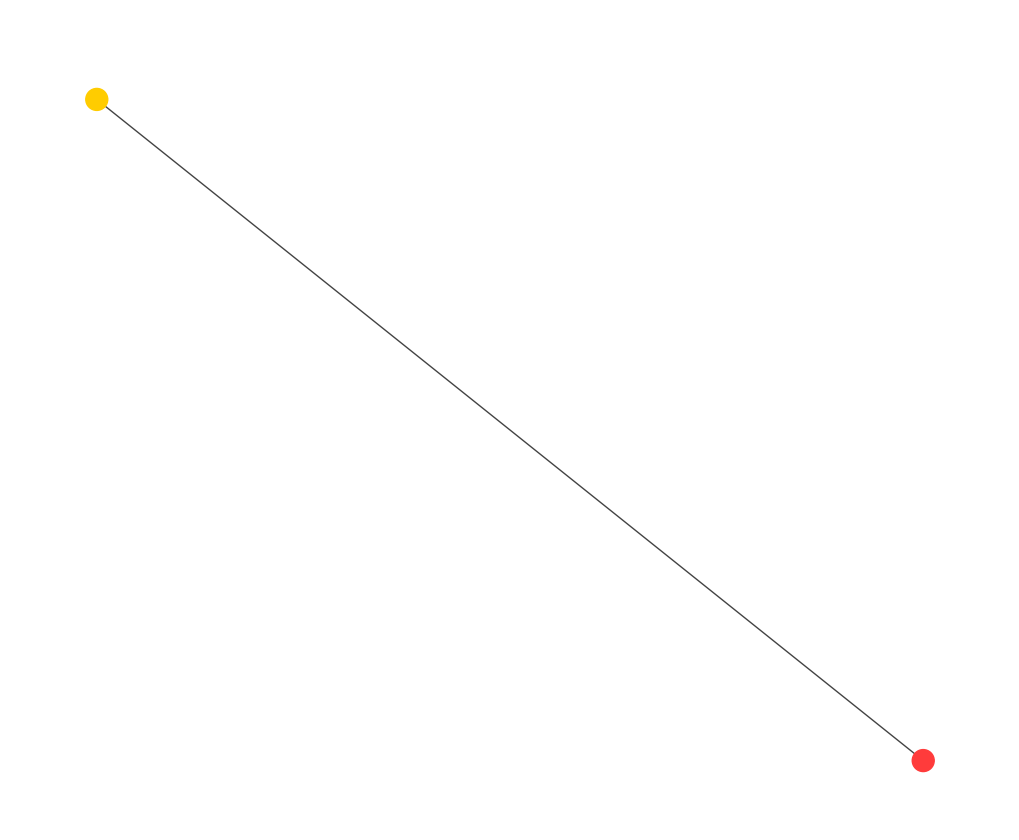

In [6]:
df_risk = pd.read_csv("../data/processed/final_risk_scored.csv")
edgelist = pd.read_csv("../data/raw/elliptic_txs_edgelist.csv")

top_tx = df_risk.sort_values("risk_score", ascending=False).iloc[0]["txId"]
neighbors = edgelist[(edgelist["txId1"] == top_tx) | (edgelist["txId2"] == top_tx)]

G = nx.from_pandas_edgelist(neighbors, "txId1", "txId2")

color_map = []
for node in G.nodes():
    if node == top_tx:
        color_map.append(COL_FRAUD)
    elif node in df_risk[df_risk.risk_score > 50]["txId"].values:
        color_map.append(COL_RISK)
    else:
        color_map.append(COL_SAFE)

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=color_map, edge_color=COL_EDGE, node_size=250)
plt.title(f"Money Flow Graph - Suspicious Wallet: {top_tx}", fontsize=12, color="white")
plt.show()


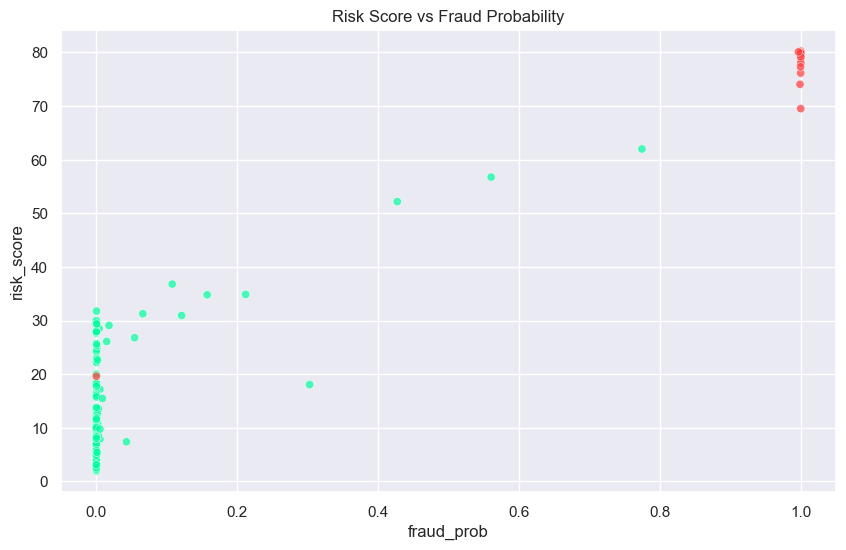

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_risk.sample(2000),
    x="fraud_prob", y="risk_score",
    alpha=0.7,
    hue=(df_risk.binary_label == 1),
    palette={True: COL_FRAUD, False: COL_SAFE},
    legend=False
)
plt.title("Risk Score vs Fraud Probability")
plt.show()


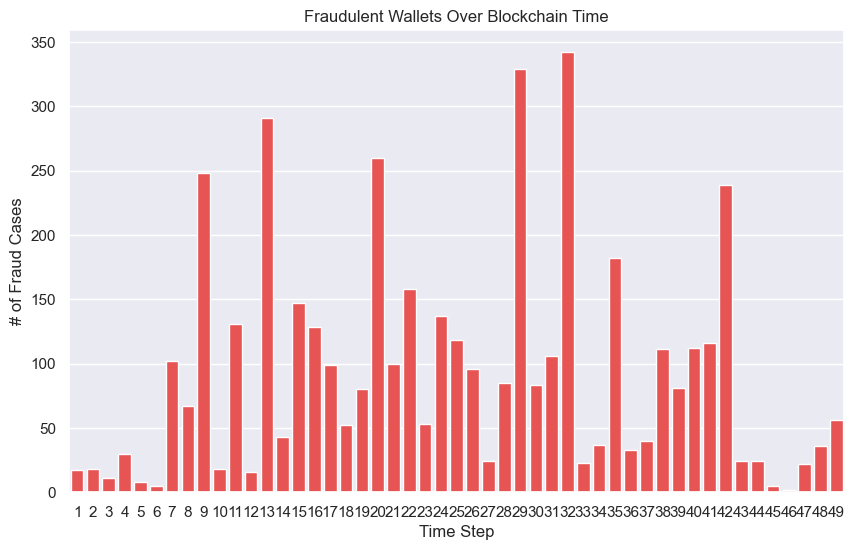

In [14]:
df = pd.read_csv("../data/processed/full_graph_data.csv")

timesteps = df[df.binary_label == 1]["f1"].astype(int)
plt.figure(figsize=(10,6))
sns.countplot(x=timesteps, color=COL_FRAUD)
plt.title("Fraudulent Wallets Over Blockchain Time")
plt.xlabel("Time Step")
plt.ylabel("# of Fraud Cases")
plt.show()


In [12]:
print(df_risk.columns)


Index(['txId', 'gnn_fraud_prob', 'fraud_prob', 'anomaly_score',
       'anomaly_score_norm', 'risk', 'risk_score', 'alert', 'binary_label'],
      dtype='object')


In [11]:
# Load main dataset with labels
df_labels = pd.read_csv("../data/processed/full_graph_data.csv")[["txId", "binary_label"]]

# Merge into risk file
df_risk = df_risk.merge(df_labels, on="txId", how="left")
